# rotate shape - shapely

In [2]:
# -*- coding: utf-8 -*-
#from FreeCAD import Base
#import Part
%matplotlib inline
import numpy as np
import os
import pprint
import matplotlib.pyplot as plt

#import numpy as np
import matplotlib
#import matplotlib.pyplot as plt
#from matplotlib import path

import shapely
from shapely.geometry import Polygon
from shapely import speedups
#from shapely.errors import TopologicalError

import warnings
warnings.filterwarnings('ignore')

from scipy.optimize import differential_evolution, basinhopping, shgo, dual_annealing
import cv2

from sections import section, VERTEX_FUNCTIONS

import json
import pandas as pd

In [3]:
# TODO: Klasse machen

def rotx(xyz, pref, phi, as2d=True):
    c = np.cos(phi)
    s = np.sin(phi)
    T = np.array([[1,0,0], [0,c,s], [0,-s,c]])

    coords2d = (xyz-pref).dot(T)
    if as2d: 
        return coords2d[:,[0,2]]
    else:
        return coords2d

def make_poly(d):
    phi = d['phi']
    pref = np.array(d['pref']).reshape((1,3))
    poly = Polygon()
    for contour in d['outer']:
        xyz = np.array(contour)
        xy = rotx(contour, pref, phi)
        poly = poly.union(Polygon(xy))
    for contour in d['inner']:
        xyz = np.array(contour)
        xy = rotx(contour, pref, phi)
        poly = poly.difference(Polygon(xy))
    return poly
            
def iou(shape1, shape2):
    """return iou (float)"""
    intersection = shape1.intersection(shape2)
    union = shape1.union(shape2)
    return intersection.area / union.area

## Load one

could be Frame_sheet_1.4_rim


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>profile</th>
      <th>mattype</th>
      <th>metallicmaterial</th>
      <th>billet</th>
      <th>ba</th>
      <th>bf</th>
      <th>blf</th>
      <th>h</th>
      <th>ra</th>
      <th>rf</th>
      <th>rlf</th>
      <th>t</th>
      <th>profile_type</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>317</th>
      <td>Frame_sheet_1.4_rim</td>
      <td>Metal</td>
      <td>Al2024T42</td>
      <td>1.4</td>
      <td>20.0</td>
      <td>20.0</td>
      <td>8.0</td>
      <td>60.0</td>
      <td>3.0</td>
      <td>3.0</td>
      <td>3.0</td>
      <td>1.4</td>
      <td>Fra_Z_2_b</td>
    </tr>
  </tbody>
</table>


In [4]:
with open("out/D5337003820400_001_SOL01_001__framecut.json", encoding='utf-8') as fp:
    d = json.load(fp)

138.3523140347979


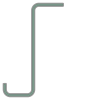

In [5]:
cad = make_poly(d[10])
print(cad.area)
cad

138.24643412849696


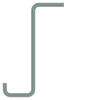

In [6]:
#isami = section('z02c', 60, 1.4, 20, 3, 20, 3, 8, 3)
isami = section('z02c', 60, 1.4, 20, 3, 19.8, 3, 8, 3)
print(isami.area)
isami = shapely.affinity.rotate(isami, 180)
isami

In [7]:
xc, yc = cad.centroid.coords[:][0]
cad0 = shapely.affinity.translate(cad, -xc, -yc)
xc, yc = isami.centroid.coords[:][0]
isami0 = shapely.affinity.translate(isami, -xc, -yc)

In [8]:
iou(cad0, isami0)

0.9905704907093799

In [10]:

if __name__ == '__main__':
    from FreeCAD import Base
    
    docname = "MyDoc"
    App.newDocument(docname)
    App.setActiveDocument(docname)
    doc = App.getDocument(docname)

    #fname_1 = u"D:/StgZ2a.step"
    fname_1 = u"D:/temp/stringers/D53376656201_sect_1.step"
    fname_2 = u"D:/stg_z4a.step"

    # for principal inertias and center of mass, I need part features...
    shape1 = Part.read(fname_1)
    part1 = doc.addObject("Part::Feature", "part1")
    part1.Shape = shape1
    cg1 = part1.Shape.CenterOfMass
    shape_to_xy(shape1, cg1)

    shape2 = Part.read(fname_2)
    part2 = doc.addObject("Part::Feature", "part2")
    part2.Shape = shape2
    cg2 = part2.Shape.CenterOfMass
    shape_to_xy(shape2, cg2)

    #print(part1.Shape.Area, part1.Shape.PrincipalProperties)
    #print(part2.Shape.Area, part2.Shape.PrincipalProperties)

    # create a mirror for shape 1 / mirror at x axis
    shape1m = shape1.copy()
    shape1m.rotate(Base.Vector(0,0,0), Base.Vector(1,0,0), 180)
    #doc.recompute()

    dalpha = 2
    alpha = np.arange(0, 360, dalpha)
    nalpha = len(alpha)
    iou = np.zeros((nalpha, 2))

    best_iou = 0
    best_angle = 0
    best_shapes = (None, None)

    for i in range(nalpha):
        angle = alpha[i]
        s = shape2.copy()
        s.rotate(Base.Vector(0,0,0), Base.Vector(0,0,1), angle)

        intersect = shape1.common(s)
        diff1 = shape1.cut(s)
        diff2 = s.cut(shape1)
        
        intersect_m = shape1m.common(s)
        diff1_m = shape1m.cut(s)
        diff2_m = s.cut(shape1m)

        ai, ad1, ad2 = intersect.Area, diff1.Area, diff2.Area
        aim, ad1m, ad2m = intersect_m.Area, diff1_m.Area, diff2_m.Area

        iou[i, 0] = ai/(ai+ad1+ad2) 
        iou[i, 1] = aim/(aim+ad1m+ad2m)

        for j, s1 in [(0, shape1), (1, shape1m)]:
            if iou[i,j] > best_iou:
                best_angle = angle
                best_iou = iou[i,j]
                best_shapes = (s1, s)

    print(alpha)
    print(best_angle, best_iou)
    print(iou)

    # save best
    s1, s2 = best_shapes
    s1.exportStep("d:/s1.step")
    s2.exportStep("d:/s2.step")

ModuleNotFoundError: No module named 'FreeCAD'